In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import scipy as sp

import portfolio_functions as pf
from pandas_datareader import data, wb
import GARCH_MPL as gml

%pylab inline
%matplotlib inline

no talib
Populating the interactive namespace from numpy and matplotlib


# GARCH

In [35]:
# Simulate GARCH
pars = [0.03123, 0.06123, 0.90123]
sz = 300

# Sim data
sdata = gml.simulate_2(pars, sz)

# Compare Modified Prof. Likelihood with QML 

In [ ]:
gml = reload(gml)
qmlHat, mplOHat, mplGHat, mplBHat = gml.get_all_estimators(sdata)

In [97]:
print(pars)
print('-----')
print('qml       %s'%qmlHat)
print('MPL_Omega %s'%mplOHat)
print('MPL_Gamma %s'%mplGHat)
print('MPL_Beta  %s'%mplBHat)

[0.03123, 0.06123, 0.90123]
-----
qml       [ 0.02584369  0.06607634  0.89215926]
MPL_Omega [ 0.03210526  0.06891387  0.88038577]
MPL_Gamma [ 0.02460083  0.06157895  0.89801538]
MPL_Beta  [ 0.02247858  0.06049159  0.90263158]


## Can we estimate MPL as LP ?

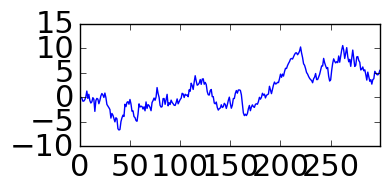

In [125]:
# Simulate GARCH
pars = [0.03123, 0.06123, 0.90123]
sz = 300

# simul
sdata = gml.simulate_2(pars, sz)

# Visual inspection
sdata.cumsum().plot(figsize=(4,2))
plt.tight_layout()

In [126]:
# Modified profile likelihood, profile likelihood, and estimated parameters: omega
lpO, lmO, phatLPO, phatLMO = gml.estimate_profile_and_modified_lik(sdata, omega=True)

# Modified profile likelihood, profile likelihood, and estimated parameters: gamma
lpG, lmG, phatLPG, phatLMG = gml.estimate_profile_and_modified_lik(sdata, omega=False)

# Modified profile likelihood, profile likelihood, and estimated parameters: beta
lpB, lmB, phatLPB, phatLMB = gml.estimate_profile_and_modified_lik_beta(sdata)

In [127]:
print(pars)
print('-----')
print('OMEGA')
print('------')
print('lp = %s'%phatLPO)
print('lm = %s'%phatLMO)
print('GAMMA')
print('------')
print('lp = %s'%phatLPG)
print('lm = %s'%phatLMG)
print('BETA')
print('------')
print('lp = %s'%phatLPB)
print('lm = %s'%phatLMB)

[0.03123, 0.06123, 0.90123]
-----
OMEGA
------
lp = [ 0.02473684  0.04975745  0.91908384]
lm = [ 0.01736842  0.04950408  0.92837466]
GAMMA
------
lp = [ 0.02360865  0.04684211  0.923238  ]
lm = [ 0.34610672  0.12052632  0.50190665]
BETA
------
lp = [ 0.02158582  0.04647693  0.92631579]
lm = [ 0.0325317   0.05648489  0.90263158]


# What's next 

In [128]:
# Pre-Assign
_Lp_parsO = []
_Lm_parsO = []

_Lp_parsG = []
_Lm_parsG = []

_Lp_parsB = []
_Lm_parsB = []


pars = [0.03123, 0.06123, 0.90123]
sz = 300

# SIMLATION
for i in range(50):
    # SIMULATE AND ESTIMATE
    sdata = gml.simulate_2(pars, sz)
    
    # Modified profile likelihood, profile likelihood, and estimated parameters: omega
    lpO, lmO, phatLPO, phatLMO = gml.estimate_profile_and_modified_lik(sdata, omega=True)

    # Modified profile likelihood, profile likelihood, and estimated parameters: gamma
    lpG, lmG, phatLPG, phatLMG = gml.estimate_profile_and_modified_lik(sdata, omega=False)

    # Modified profile likelihood, profile likelihood, and estimated parameters: beta
    lpB, lmB, phatLPB, phatLMB = gml.estimate_profile_and_modified_lik_beta(sdata)

    _Lp_parsO.append(phatLPO)
    _Lm_parsO.append(phatLMO)
    
    _Lp_parsG.append(phatLPG)
    _Lm_parsG.append(phatLMG)
    
    _Lp_parsB.append(phatLPB)
    _Lm_parsB.append(phatLMB)

In [150]:
pd.DataFrame(_Lp_parsO).std(axis=0)

0    0.041943
1    0.034029
2    0.065127
dtype: float64

In [153]:
pd.DataFrame(_Lm_parsO).mean(axis=0)

0    0.049495
1    0.067531
2    0.873426
dtype: float64

In [154]:
pd.DataFrame(_Lp_parsB).mean(axis=0)

0    0.075432
1    0.063367
2    0.843895
dtype: float64

In [155]:
pd.DataFrame(_Lm_parsB).mean(axis=0)

0    0.125349
1    0.065727
2    0.780895
dtype: float64

In [146]:
pd.DataFrame(_Lp_parsG).mean(axis=0)

0    0.080974
1    0.063495
2    0.835861
dtype: float64

In [147]:
pd.DataFrame(_Lm_parsG).mean(axis=0)

0    0.156326
1    0.060105
2    0.749199
dtype: float64